In [0]:
!pip install kaggle

In [2]:
import json
!mkdir .kaggle
token = {"username":"raviraj0104","key":"acfb5ca1842ad1423bb1da3f6d5cd7b5"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [3]:
!kaggle datasets list -s 'Pneumonia'

ref                                                   title                                           size  lastUpdated          downloadCount  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
paultimothymooney/chest-xray-pneumonia                Chest X-Ray Images (Pneumonia)                   2GB  2018-03-24 19:41:59          50219  
sudalairajkumar/novel-corona-virus-2019-dataset       Novel Corona Virus 2019 Dataset                798KB  2020-04-21 03:55:31         154830  
imdevskp/corona-virus-report                          COVID-19 Dataset                                 8MB  2020-04-21 09:01:32          31334  
parthachakraborty/pneumonia-chest-x-ray               Pneumonia Chest X ray                            2GB  2018-08-16 07:48:39            566  
khoongweihao/covid19-xray-dataset-train-test-sets     COVID-19 Xray Dataset (Train & Test Sets)       84MB  2020-03-19 01:49:56   

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --force

100% 2.29G/2.29G [00:28<00:00, 38.2MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.7MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [6]:
!ls

chest_xray  chest-xray-pneumonia.zip  sample_data


In [0]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
IMG_SIZE = 200
labels = ['PNEUMONIA','NORMAL']

pneumonia_count = 0
normal_count = 0
def get_training_data(data_dir):
  training_data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for f in tqdm(os.listdir(path)):
      try:
        filepath = os.path.join(path, f)
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.eye(2)[labels.index(label)]])

        if label == labels[0]:
          pneumonia_count += 1
        if label == labels[1]:
          normal_count += 1
      except:
        pass

  np.random.shuffle(training_data)
  #np.save("training_data_xray.npy",self.training_data)
  return training_data
        

dirpaths = ['chest_xray/train/','chest_xray/test/','chest_xray/val/']

train = get_training_data(dirpaths[0])

test = get_training_data(dirpaths[1])

val = get_training_data(dirpaths[2])

100%|██████████| 8/8 [00:00<00:00, 82.15it/s]


[1. 0.]


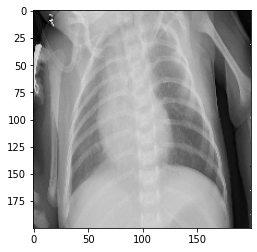

In [9]:
plt.imshow(train[15][0],cmap='gray')
print(train[15][1])

In [0]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

In [11]:
len(X),len(y)

(5856, 5856)

In [0]:
del(train)
del(test)
del(val)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [31]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,64,5)
    self.conv3 = nn.Conv2d(64,128,5)

    x = torch.rand(200,200).view(-1,1,200,200)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear,512)
    self.fc2 = nn.Linear(512,2)

  def convs(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)),(2,2)) 

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self,x):
    x = self.convs(x)
    x = x.view(-1,self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x,dim=1) 

net = Net()
net = net.double()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=56448, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [0]:

X = torch.tensor([i for i in X]).view(-1,200,200)
y = torch.tensor([i for i in y])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=32,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32,stratify=y_temp)

del(X_temp)
del(y_temp)

X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

In [32]:
BATCH_SIZE= 100
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=0.0001)
loss_fn = nn.MSELoss()
for epoch in range(epochs):
  for i in tqdm(range(0,len(X_train),BATCH_SIZE)):
    steps += 1
    batch_x = X_train[i:i+BATCH_SIZE].view(-1,1,200,200)
    batch_y = y_train[i:i+BATCH_SIZE]
    batch_x = batch_x.double().to(device)
    batch_y = batch_y.to(device)

    net.zero_grad()
    output = net(batch_x.double())
    loss = loss_fn(output,batch_y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if steps % print_every == 0:
      net.eval()
      test_loss = 0
      acc = 0
      with torch.no_grad():
        for i in range(0,len(X_val),BATCH_SIZE):
          inputs = X_val[i:i+BATCH_SIZE].view(-1,1,200,200)
          labels = y_val[i:i+BATCH_SIZE]
          inputs, labels = inputs.to(device),labels.to(device)
          net_out = net(inputs.view(-1,1,200,200).double())
          matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(net_out,labels)]
          acc += matches.count(True)        
          batch_loss = loss_fn(net_out,labels)
          test_loss += batch_loss.item()
      train_losses.append(running_loss/len(X_train))
      test_losses.append(test_loss/len(X_val))                 
      print(f"Epoch {epoch+1}/{epochs}.. Train loss: {running_loss/len(X_train):.3f}.. Test loss: {test_loss/len(X_val):.3f} .. Accuracy:{acc/len(X_val)*100:.3f}")
      running_loss = 0
      net.train()

 24%|██▍       | 10/41 [00:14<01:04,  2.07s/it]

Epoch 1/10.. Train loss: 0.000.. Test loss: 0.002 .. Accuracy:72.924


 49%|████▉     | 20/41 [00:28<00:44,  2.10s/it]

Epoch 1/10.. Train loss: 0.000.. Test loss: 0.002 .. Accuracy:73.038


 73%|███████▎  | 30/41 [00:43<00:23,  2.11s/it]

Epoch 1/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:89.420


 98%|█████████▊| 40/41 [00:57<00:02,  2.11s/it]

Epoch 1/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:91.354


 22%|██▏       | 9/41 [00:13<01:06,  2.09s/it]

Epoch 2/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:90.785


 46%|████▋     | 19/41 [00:27<00:46,  2.11s/it]

Epoch 2/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:92.491


 71%|███████   | 29/41 [00:42<00:25,  2.11s/it]

Epoch 2/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:91.240


 95%|█████████▌| 39/41 [00:56<00:04,  2.11s/it]

Epoch 2/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:89.989


 20%|█▉        | 8/41 [00:12<01:08,  2.08s/it]

Epoch 3/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:93.629


 44%|████▍     | 18/41 [00:26<00:48,  2.10s/it]

Epoch 3/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:94.312


 68%|██████▊   | 28/41 [00:41<00:27,  2.11s/it]

Epoch 3/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:94.312


 93%|█████████▎| 38/41 [00:55<00:06,  2.12s/it]

Epoch 3/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:94.881


 17%|█▋        | 7/41 [00:11<01:11,  2.09s/it]

Epoch 4/10.. Train loss: 0.000.. Test loss: 0.001 .. Accuracy:92.264


 41%|████▏     | 17/41 [00:25<00:50,  2.11s/it]

Epoch 4/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.222


 66%|██████▌   | 27/41 [00:40<00:29,  2.11s/it]

Epoch 4/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.449


 90%|█████████ | 37/41 [00:54<00:08,  2.11s/it]

Epoch 4/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.222


 15%|█▍        | 6/41 [00:09<01:13,  2.09s/it]

Epoch 5/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:94.425


 39%|███▉      | 16/41 [00:24<00:52,  2.12s/it]

Epoch 5/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.222


 63%|██████▎   | 26/41 [00:39<00:31,  2.12s/it]

Epoch 5/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:93.743


 88%|████████▊ | 36/41 [00:53<00:10,  2.11s/it]

Epoch 5/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.336


 12%|█▏        | 5/41 [00:08<01:15,  2.09s/it]

Epoch 6/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.563


 37%|███▋      | 15/41 [00:23<00:54,  2.11s/it]

Epoch 6/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.563


 61%|██████    | 25/41 [00:37<00:33,  2.11s/it]

Epoch 6/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.336


 85%|████████▌ | 35/41 [00:52<00:12,  2.12s/it]

Epoch 6/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.222


 10%|▉         | 4/41 [00:07<01:17,  2.09s/it]

Epoch 7/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.336


 34%|███▍      | 14/41 [00:22<00:57,  2.12s/it]

Epoch 7/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.222


 59%|█████▊    | 24/41 [00:36<00:36,  2.12s/it]

Epoch 7/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.018


 83%|████████▎ | 34/41 [00:51<00:14,  2.11s/it]

Epoch 7/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:94.198


  7%|▋         | 3/41 [00:06<01:19,  2.09s/it]

Epoch 8/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.791


 32%|███▏      | 13/41 [00:21<00:59,  2.12s/it]

Epoch 8/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:93.629


 56%|█████▌    | 23/41 [00:35<00:38,  2.12s/it]

Epoch 8/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.018


 80%|████████  | 33/41 [00:50<00:16,  2.11s/it]

Epoch 8/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.336


  5%|▍         | 2/41 [00:05<01:21,  2.08s/it]

Epoch 9/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.108


 29%|██▉       | 12/41 [00:19<01:01,  2.11s/it]

Epoch 9/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.132


 54%|█████▎    | 22/41 [00:34<00:40,  2.11s/it]

Epoch 9/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.246


 78%|███████▊  | 32/41 [00:48<00:19,  2.12s/it]

Epoch 9/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.791


  2%|▏         | 1/41 [00:04<02:52,  4.32s/it]

Epoch 10/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.018


 27%|██▋       | 11/41 [00:18<01:05,  2.17s/it]

Epoch 10/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.018


 51%|█████     | 21/41 [00:33<00:42,  2.12s/it]

Epoch 10/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.904


 76%|███████▌  | 31/41 [00:47<00:21,  2.11s/it]

Epoch 10/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:95.677


100%|██████████| 41/41 [01:02<00:00,  1.52s/it]

Epoch 10/10.. Train loss: 0.000.. Test loss: 0.000 .. Accuracy:96.246


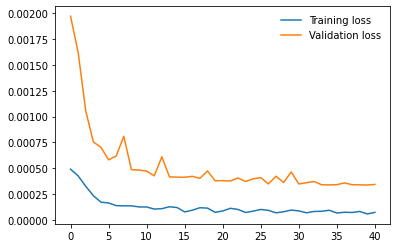

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [34]:
correct =0
total =0
with torch.no_grad():
  for i in tqdm(range(len(X_test))):
    real_class = torch.argmax(y_test[i])
    net.to("cpu")
    net_out = net(X_test[i].view(-1,1,200,200).double())[0]
    predicted_class = torch.argmax(net_out)
    if predicted_class == real_class:
      correct +=1
    total +=1
print("Accruracy is"+str(round(correct/total*100,3)))

100%|██████████| 878/878 [02:04<00:00,  7.03it/s]

Accruracy is96.469


In [37]:
from google.colab import files
files.download('/content/PneumoniaClassifier_final1.pt')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 50574, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [36]:
torch.save(net,'/content/PneumoniaClassifier_final1.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model = torch.load('/content/PneumoniaClassifier_final1.pt')
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=56448, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)